[View in Colaboratory](https://colab.research.google.com/github/shimo8810/discord_bot/blob/master/deep_learning/colab/vae.ipynb)

# Google Colab. VAE Test
パクリ元  
[chainer/examples/vae](https://github.com/chainer/chainer/blob/master/examples/vae/train_vae.py)

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0  18635      0 --:--:-- --:--:-- --:--:-- 18635
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer.functions.loss.vae import gaussian_kl_divergence
from chainer import datasets, iterators, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [3]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


## Parameter

In [0]:
epoch = 100
dimz = 50
batchsize = 512

out_dir = 'vae_result'

## Network

In [0]:
class VAE(chainer.Chain):

    def __init__(self, n_in, n_latent, n_h):
        super(VAE, self).__init__()
        with self.init_scope():
            # encoder
            self.le1 = L.Linear(n_in, n_h)
            self.le2_mu = L.Linear(n_h, n_latent)
            self.le2_ln_var = L.Linear(n_h, n_latent)
            # decoder
            self.ld1 = L.Linear(n_latent, n_h)
            self.ld2 = L.Linear(n_h, n_in)

    def forward(self, x, sigmoid=True):
        return self.decode(self.encode(x)[0], sigmoid)

    def encode(self, x):
        h1 = F.tanh(self.le1(x))
        mu = self.le2_mu(h1)
        ln_var = self.le2_ln_var(h1)  # log(sigma**2)
        return mu, ln_var

    def decode(self, z, sigmoid=True):
        h1 = F.tanh(self.ld1(z))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, beta=1.0, k=1):
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu)
            # reconstruction loss
            rec_loss = 0
            for l in range(k):
                z = F.gaussian(mu, ln_var)
                rec_loss += F.bernoulli_nll(x, self.decode(z, sigmoid=False)) \
                    / (k * batchsize)
            self.rec_loss = rec_loss
            self.loss = self.rec_loss + \
                beta * gaussian_kl_divergence(mu, ln_var) / batchsize
            chainer.report(
                {'rec_loss': rec_loss, 'loss': self.loss}, observer=self)
            return self.loss
        return lf

## Dataset

In [0]:
train, test = chainer.datasets.get_mnist(withlabel=False)
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                repeat=False, shuffle=False)

## Setup

In [0]:
# Prepare VAE mode
model = VAE(784, dimz, 500)

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Set up an updater
updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=0, loss_func=model.get_loss_func())

# Set up a Trainer
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

# Set up Updater Extentions
trainer.extend(extensions.Evaluator(test_iter, model, device=0,
                                    eval_func=model.get_loss_func(k=10)))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.snapshot_object(
    model, filename='model_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))

## Train

In [8]:
trainer.run()

epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           207.109     157.012               184.108        132.477                   2.51473       
2           147.974     139.44                119.574        108.757                   4.62535       
3           136.571     131.741               104.922        99.2117                   6.70322       
4           130.427     127.07                97.6974        94.1736                   8.75285       
5           126.526     123.837               93.3386        90.1103                   10.7946       
6           123.782     121.656               90.6103        88.7814                   12.8434       
7           121.921     120.144               88.8119        87.3439                   14.8781       
8           120.387     118.786               87.4625        86.0654                   16.9041       
9           119.195     117.706               86.4527        84.9922                

## Reconstruct Test

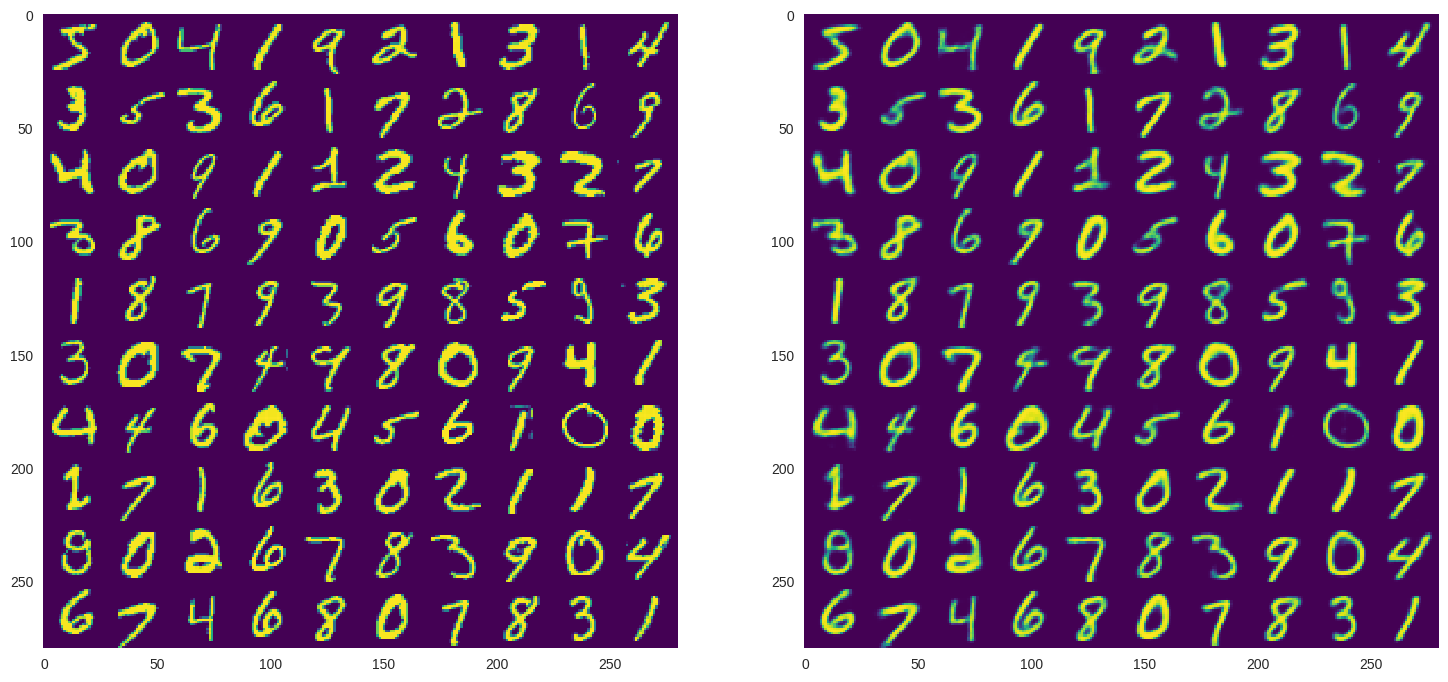

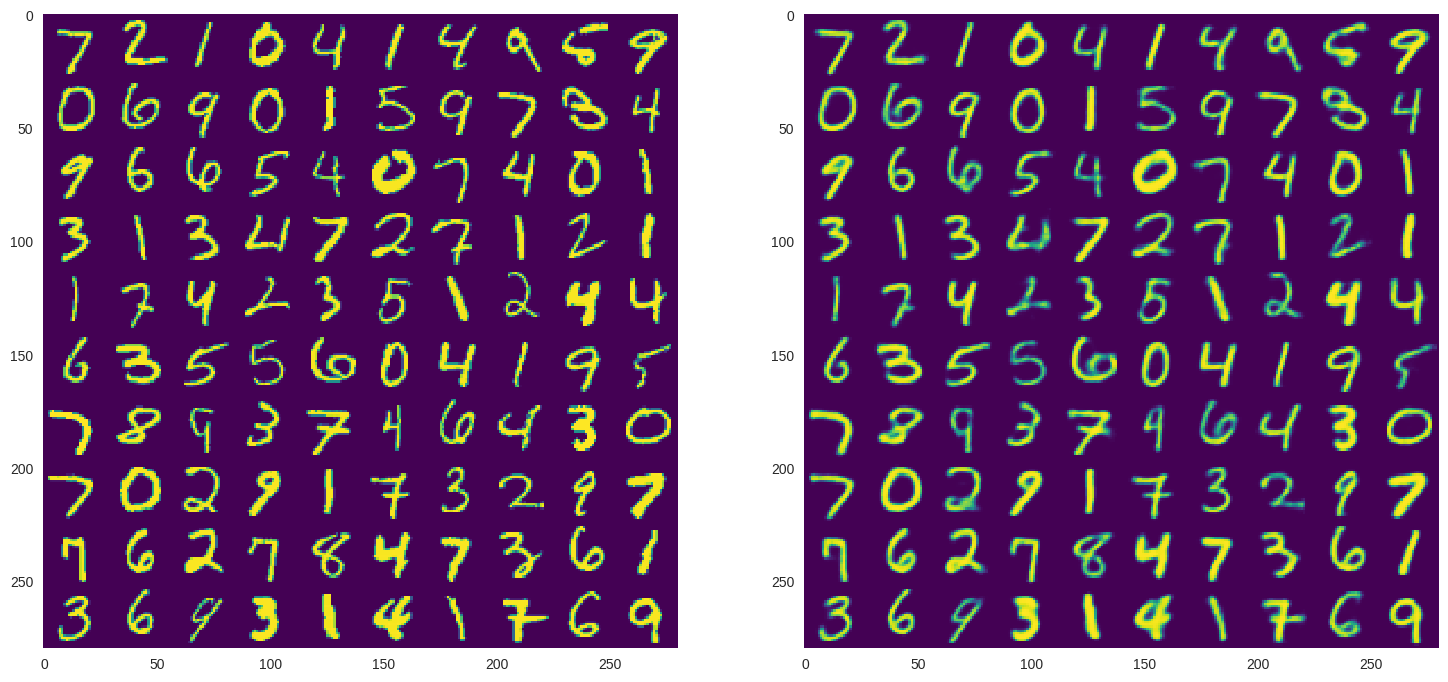

In [11]:
model.to_cpu()
# train data
x_in = np.array(train[:100])
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x_out = model(x_in).data

fig, ax = plt.subplots(1, 2, figsize=(18, 9), dpi=100)
for ai, x in zip(ax.flatten(), (x_in, x_out)):
    x = x.reshape(10, 10, 28, 28).transpose(0,2,1,3).reshape(280, 280)
    ai.grid(False)
    ai.imshow(x, cmap='viridis')

fig.savefig(os.path.join(out_dir, 'train_reconstructed_image.png'))

# test data
x_in = np.array(test[:100])
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x_out = model(x_in).data

fig, ax = plt.subplots(1, 2, figsize=(18, 9), dpi=100)
for ai, x in zip(ax.flatten(), (x_in, x_out)):
    x = x.reshape(10, 10, 28, 28).transpose(0,2,1,3).reshape(280, 280)
    ai.grid(False)
    ai.imshow(x, cmap='viridis')
    
fig.savefig(os.path.join(out_dir, 'test_reconstructed_image.png'))

## Sampling Test

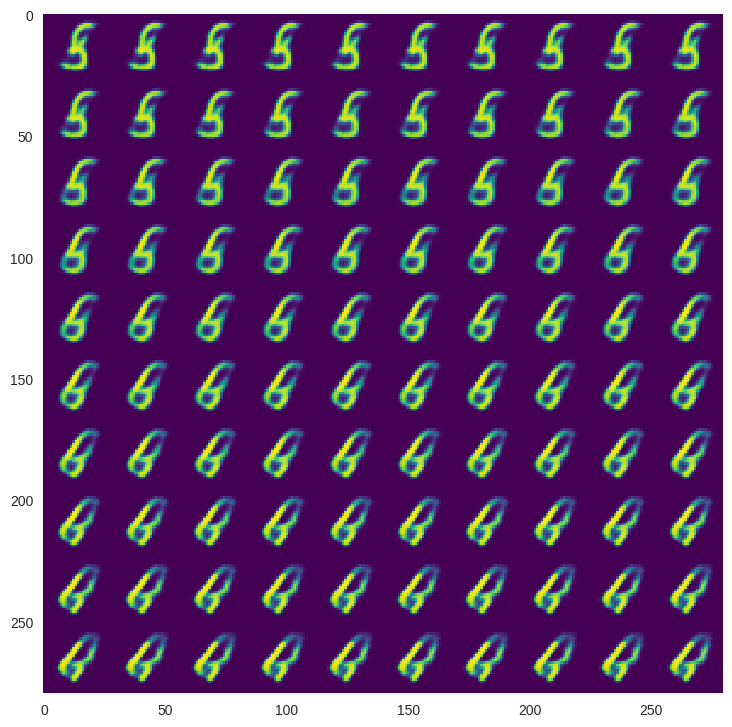

In [12]:
z1, z2 = np.random.normal(0, 1, (2, dimz))
z = z1 + np.kron(np.linspace(0, 1, 100).reshape(100, 1), (z2 - z1))
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x = model.decode(z.astype(np.float32)).data

plt.figure(figsize=(9, 9), dpi=100)
plt.imshow(x.reshape(10, 10, 28, 28).transpose(0,2,1,3).reshape(10*28, 10*28), 
          cmap='viridis')
plt.grid(False)
plt.savefig(os.path.join(out_dir, 'sampled_image.png'))
plt.show()